### Direct Marketing in Banking - Propensity Modelling with Tabular Data

# Part 1: SageMaker Autopilot, XGBoost, and HPO

> *이 노트북은 SageMaker Studio의 `Python 3 (Data Science 3.0)` 커널과 잘 작동합니다.*

이 워크샵에서는 클래스 불균형이 심각한 표 형식의 [binary classification](https://en.wikipedia.org/wiki/Binary_classification) 사용 사례, 즉 은행의 어떤 고객이 타겟 마케팅 캠페인에 응답할 가능성이 높은지 예측하는 사례를 살펴 봅니다.

이 노트북에서는 먼저 [Amazon SageMaker Autopilot]()을 사용하여 AutoML로 문제를 해결한 다음, [SageMaker built-in XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) 과 [automatic hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) 을 통해 더 깊이 있게 살펴 봅니다.

## Contents

> ℹ️ **Tip:** JupyterLab / SageMaker Studio의 왼쪽 사이드바에 있는 목차 패널을 사용하여 섹션을 보고 탐색할 수 있습니다.

1. **[Prepare our environment](#Prepare-our-environment)**
1. **[Fetch the example dataset](#Fetch-the-example-dataset)**
1. **[Starting fast with SageMaker Autopilot](#Starting-fast-with-SageMaker-Autopilot)**
1. **[Diving deeper with XGBoost](#Diving-deeper-with-XGBoost)**
1. **[Hyperparameter Optimization (HPO)](#Hyperparameter-Optimization-(HPO))**
1. **[Conclusions](#Conclusions)**

## Prepare our environment

시작하려면 다음을 수행해야 합니다:

- **Import** some useful libraries (as in any Python notebook)
- **Configure** -
    - The [Amazon S3 bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html#CoreConcepts) and folder where **data** should be stored (to keep our environment tidy)
    - The [IAM role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) defining what **permissions** the jobs you create will have
- **Connect** to AWS in general (with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

아래 셀을 실행하여 이를 설정 합니다.

> ℹ️ **Tip:** [JupyterLab notebook](https://jupyterlab.readthedocs.io/en/stable/user/interface.html) 에서와 마찬가지로, 대상 셀을 클릭한 다음 도구 모음에서 재생(▶️) 버튼을 누르거나 키보드에서 `Shift+Enter` 를 눌러 코드 셀을 실행할 수 있습니다.

In [2]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import json
import time

# External Dependencies:
import boto3  # General-purpose AWS SDK for Python
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # Tabular data utilities
import sagemaker  # High-level SDK specifically for Amazon SageMaker
from sagemaker.automl.automl import AutoML as AutoMLEstimator
from sagemaker.feature_store.feature_group import FeatureGroup

# Local Helper Functions:
import util

# Setting up SageMaker parameters
sgmk_session = sagemaker.Session()  # Connect to SageMaker APIs
region = sgmk_session.boto_session.region_name  # The AWS Region we're using (e.g. 'ap-southeast-1')
bucket_name = sgmk_session.default_bucket()  # Select an Amazon S3 bucket
bucket_prefix = "sm101/direct-marketing"  # Location in the bucket to store our files
sgmk_role = sagemaker.get_execution_role()  # IAM Execution Role to use for permissions

print(f"s3://{bucket_name}/{bucket_prefix}")
print(sgmk_role)

s3://sagemaker-us-east-1-151772765882/sm101/direct-marketing
arn:aws:iam::151772765882:role/cfn-SageMakerExecutionRole-1SEFDF0K84M6L


## Fetch the example dataset

이번 예시에서는 [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) 을 사용 합니다. : S. Moro, P. Cortez and P. Rita. *은행 텔레마케팅의 성공을 예측하기 위한 데이터 기반 접근 방식.* Decision Support Systems, Elsevier, 62:22-31, June 2014.

다음 셀에서는 데이터 집합을 로컬로 다운로드하여 Amazon S3에 저장하고 변환된 사본을 [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/) 에 로드 합니다.

> ℹ️ **Tip:** SageMaker Feature Store를 **사용하지 않고도** SageMaker에서 모델을 훈련하고 배포할 수 있지만, 이 예제에서는 더 다양한 SageMaker 기능을 보여드리기 위해 소개합니다.
>
> 여기서 데이터 로딩이 어떻게 수행되는지에 대한 세부 사항에 대해 너무 걱정하지 마시고, 궁금한 점이 있으면 [util/data.py](util/data.py) 에서 이러한 헬퍼 함수 뒤에 있는 코드를 확인할 수 있습니다.

In [3]:
raw_data_path = util.data.fetch_sample_data()
print(f"Got: {raw_data_path}\n")

print("Uploading raw dataset to Amazon S3:")
raw_data_s3uri = f"s3://{bucket_name}/{bucket_prefix}/raw.csv"
!aws s3 cp {raw_data_path} {raw_data_s3uri}

https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Extracting to data...
Got: data/bank-additional/bank-additional-full.csv

Uploading raw dataset to Amazon S3:
upload: data/bank-additional/bank-additional-full.csv to s3://sagemaker-us-east-1-151772765882/sm101/direct-marketing/raw.csv


In [4]:
%%time
feature_group_name = "sm101-direct-marketing"
print("Loading data to SageMaker Feature Store:")

# No need to re-run this if you've done it already - just set `feature_group_name` variable.
util.data.load_sample_data(
    raw_data_path,
    fg_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/feature-store",
    feature_group_name=feature_group_name,
    ignore_cols=[
        "duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
    ],
)

Loading data to SageMaker Feature Store:
Loading data/bank-additional/bank-additional-full.csv...
Transforming dataframe...
Setting up SageMaker Feature Store feature group: sm101-direct-marketing
Waiting for creation of Feature Group sm101-direct-marketing (Initial status Creating)....
Feature Group sm101-direct-marketing successfully created.
Configuring feature metadata...
Ingesting data to SageMaker Feature Store...
Waiting for propagation to offline Feature Store...
Done!
CPU times: user 2.06 s, sys: 327 ms, total: 2.39 s
Wall time: 6min 41s


'sm101-direct-marketing'

> ⏰ 이 셀의 실행이 완료될 때까지 **기다릴 필요가 없습니다.** : `Ingesting data...` 단계에 도달하면 바로 다음 섹션으로 넘어갈 수 있습니다.

▶️ `Ingesting data...` 단계에 도달하자 마자 SageMaker Feature Store catalog에서 "feature group"을 볼 수 있습니다:

- SageMaker Studio의 왼쪽 사이드바에서 🏠 *SageMaker Home* 아이콘을 선택합니다. 
- 사이드바 메뉴에서 `Data > Feature Store` 를 선택하여 Feature Store UI를 엽니다.

"feature group" (table)으로 카탈로그를 검색하거나 개별 기능을 직접 검색할 수 있습니다. UCI의 데이터 세트 설명을 기반으로 설명과 일부 태그가 이미 채워져 있습니다.

![](img/feature-store-features.png "Screenshot of SMStudio Feature Store UI showing feature catalog")

## Starting fast with SageMaker Autopilot

> ℹ️ **Tip: 다음 수동 단계 건너뛰기** - 아래로 스크롤하면 API를 통해 유사한 설정을 만들 수 있는 코드를 찾을 수 있습니다.

Autopilot을 사용하면 광범위한 데이터 준비나 코드 작성 없이도 표 형식의 ML 문제를 쉽게 시작할 수 있습니다. 그 이유는 다음과 같습니다:

- Autopilot은 고성능 모델을 식별하기 위해 다양한 데이터 전처리 옵션, 알고리즘 및 하이퍼 파라미터를 자동으로 탐색합니다.
- 일부 수동 feature engineering을 먼저 수행하려는 경우에도 Autopilot은 [SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) (SageMaker's low-code/no-code data preparation tool)와 직접 통합됩니다. 런처에서 new Data Wrangler Flow을 만들거나 File > New > Data Wrangler Flow 을 만들어 이를 탐색할 수 있습니다.

▶️ 데이터를 SageMaker Feature Store로 가져오는 동안, **raw CSV 파일을 사용하여 Autopilot 실험을 시작** 하겠습니다.

1. SageMaker Studio의 왼쪽 사이드바에서 🏠 *SageMaker Home* 아이콘을 **선택합니다.**
1. 사이드바 메뉴에서 `AutoML` 을 **선택합니다.**
1. `Create Autopilot Experiment` 버튼을 **클릭 합니다.**

▶️ 첫번째 **Experiment and data details** 단계:

- **Experiment name** 을 선택합니다 - `sm101-autopilot-1` 같은 것이 좋습니다.
- **S3 location** 의 경우 `Browse` 버튼을 사용하거나 이 노트북의 앞부분에 있는 `raw_data_s3uri` 의 URI를 입력하면 됩니다.
- 다른 설정은 기본값을 유지하고 **Next** 를 클릭합니다.

![](img/autopilot-01-select-data.png "Screenshot of Autopilot workflow selecting the raw data CSV in S3")

▶️ 다음 **Experiment and data details** 단계:

- **Target** 컬럼에서 `y` 를 선택합니다.
- 이 노트북 앞 부분에 있는 `ignore_cols` 에서 feature를 **선택 취소** 하여 모델에서 **제외** 합니다.
    - ⚠️ [UCI dataset page](https://archive.ics.uci.edu/ml/datasets/bank+marketing)에서 논의한 바와 같이, `duration` 필드는 대상 변수에 대한 정보를 유출하기 때문에 모델링에 포함하기에 특히 부적합합니다. (기간이 긴 고객은 성공적인 영업 기회가 될 가능성이 높았으며, 어떤 고객에게 접근해야 할지 목표 시점에서 통화 기간을 알 수 없습니다.) 또한 추론 시간에 최종 5개의 macro-economic 변수를 쉽게 사용할 수 없을 수 있으므로 제외합니다.

![](img/autopilot-02-select-features.png "Screenshot of Autopilot workflow excluding ignored features and selecting y as target variable")

▶️ 다음 **Training method** 단계:

- 기본 **Auto** 선택 방법을 그대로 사용할 수 있습니다. 이 데이터 세트가 작기 때문에 앙상블 방법이 자동으로 선택됩니다. 원하는 경우 두 가지 방법을 비교하기 위해 두 번째 실험을 만들 수 있습니다.

![](img/autopilot-03-select-mode.png "Select Auto mode in the UI, which will be equivalent to Ensembling for this small dataset")

▶️ 다음 **Deployment and advanced settings** 단계:

- **이전 화면에서 "HPO" training method를 선택한 경우**: `Runtime > Max candidates` 설정을 250 에서 ~50으로 줄이는 것을 고려하세요. 기본 설정은 훈련하는데 몇 시간이 걸릴 수 있습니다.
- **그렇지 않으면**, 모든 설정을 기본값으로 유지

▶️ **Next를 클릭하고** 설정을 검토한 다음 **Create experiment**를 클릭합니다.

![](img/autopilot-04-runtime.png "Screenshot selecting smaller number of max candidates in runtime menu - only applicable for HPO jobs")

또는 [CreateAutoMLJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateAutoMLJob.html) 또는 아래와 같이 [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/automl.html)의 고급 `AutoML` 을 통해 Autopilot Jobs를 생성할 수 있습니다:

> ⚠️ Autopilot job을 이미 수동으로 만든 경우 다음 셀을 실행할 필요가 없습니다!

In [5]:
# There's no need to run this cell if you created an Autopilot job manually!
autopilot = AutoMLEstimator(
    role=sgmk_role,
    target_attribute_name="y",

    # At the time of writing, the high-level Python SDK didn't support ensembling mode - so we'll
    # use the HPO mode instead with limited max_candidates:
    max_candidates=20,

    # Optional params to keep the environment tidy:
    base_job_name="sm101-autopilot",
    output_path=f"s3://{bucket_name}/{bucket_prefix}/autopilot",
)

autopilot.fit(raw_data_s3uri, wait=False)

Setting logs to False. logs is only meaningful when wait is True.


## Diving deeper with XGBoost

고성능 모델을 신속하게 구축하는 또 다른 유용한 도구는 광범위한 유즈 케이스를 위해 SageMaker에서 제공하는 [built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) 세트 입니다.

데이터 사전 처리 및 하이퍼파라미터 조정 프로세스를 자동화하기 위해 Autopilot을 사용하는 대신, 우리는 이러한 빌트인 알고리즘(또는 사용자 지정 알고리즘)을 직접 사용하여 세부적인 제어를 할 수 있습니다. 이 예에서는 [XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) 을 보여드리겠습니다.


### Understand the algorithm requirements

SageMaker 빌트인 알고리즘을 사용하는 첫 번째 단계는 전체적인 특성과 제공하는 인터페이스를 이해하는 것 입니다. 여기서는 다음을 참조합니다:

- The [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to understand the **detail** of the **data formats** and **(hyper)-parameters** it supports - as well as sample notebooks
- The [Common Parameters doc](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) to compare the **high-level configurations** and capabilities between algorithms.


알고리즘 문서 페이지에서 설명한 바와 같이 SageMaker에서 XGBoost 를 사용하는 방법에는 pre-built 알고리즘 (스크립트가 필요 없음) 또는 프레임워크 (사용자 지정 훈련 스크립트 사용)의 2 가지가 있습니다.

이 예에서는 pre-built algorithm mode를 사용하므로 컨테이너 이미지 URI만 가져오면 됩니다:

In [6]:
image_uri = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")
print(image_uri)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


### Extract batch data from the SageMaker Feature Store

그런 다음 [Amazon Athena](https://aws.amazon.com/athena/)의 서버리스 SQL 쿼리를 통해 (offline/batch) SageMaker Feature Store에서 스냅샷을 추출하여 모델 훈련을 준비합니다.

Feature Store는 레코드의 **기록을 추적** 하여, feature가 시간이 지남에 따라 변경되는 경우에도 시점 스냅샷을 복제할 수 있도록 합니다.

- SageMaker Studio Feature Store UI를 통해 time-travel 및 other views에 대한 **Example queries** 를 사용할 수 있습니다. : Feature Group에서 "Sample queries" 탭으로 전환합니다.
- 아래 쿼리에서 반환된 추가 `event_time`, `write_time`, `api_invocation_time`, `is_deleted` 및 `row_number` 필드는 이 기록 추적에 대한 메타데이터이므로 실제 모델 훈련에 사용되지 않습니다.

In [7]:
feature_group = FeatureGroup(feature_group_name, sagemaker_session=sgmk_session)
query = feature_group.athena_query()
table_name = query.table_name

data_extract_s3uri = f"s3://{bucket_name}/{bucket_prefix}/data-extract"
!aws s3 rm --quiet --recursive {data_extract_s3uri}  # Clear any previous extractions
print(f"Querying feature store to extract snapshot at:\n{data_extract_s3uri}")
query.run(
    f"""
    SELECT *
    FROM
        (SELECT *,
        row_number()
        OVER
            (PARTITION BY "customer_id"
            ORDER BY "event_time" DESC, Api_Invocation_Time DESC, write_time DESC)
        AS row_number
        FROM "sagemaker_featurestore"."{table_name}"
        WHERE "event_time" <= {time.time()})
    WHERE row_number = 1 AND NOT is_deleted;
    """,
    output_location=data_extract_s3uri,
)
query.wait()

full_df = query.as_dataframe()
print(f"Got {len(full_df)} records")
full_df

Querying feature store to extract snapshot at:
s3://sagemaker-us-east-1-151772765882/sm101/direct-marketing/data-extract
Got 41188 records


,y,age,job,marital,education,default,housing,loan,contact,month,...,previous,poutcome,no_previous_contact,not_working,customer_id,event_time,write_time,api_invocation_time,is_deleted,row_number
0,0,37,admin.,married,high.school,no,yes,no,telephone,may,...,0,nonexistent,1,0,C-00000024,1.649044e+09,2023-04-04 03:48:47.064,2023-04-04 03:43:07.000,False,1
1,0,59,admin.,married,high.school,no,yes,no,cellular,apr,...,0,nonexistent,1,0,C-00028358,1.649044e+09,2023-04-04 03:48:47.064,2023-04-04 03:43:13.000,False,1
2,0,50,services,single,high.school,no,no,no,cellular,jul,...,0,nonexistent,1,0,C-00018118,1.649044e+09,2023-04-04 03:48:47.064,2023-04-04 03:43:13.000,False,1
3,0,36,technician,single,professional.course,no,no,no,telephone,may,...,0,nonexistent,1,0,C-00000241,1.649044e+09,2023-04-04 03:48:47.064,2023-04-04 03:43:13.000,False,1
4,0,30,blue-collar,married,basic.6y,no,yes,yes,cellular,jul,...,0,nonexistent,1,0,C-00013066,1.649044e+09,2023-04-04 03:48:47.064,2023-04-04 03:43:14.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,36,admin.,single,high.school,no,yes,no,cellular,may,...,0,nonexistent,1,0,C-00030747,1.649044e+09,2023-04-04 03:48:47.106,2023-04-04 03:44:22.000,False,1
41184,0,31,admin.,married,university.degree,no,yes,no,cellular,oct,...,0,nonexistent,1,0,C-00038394,1.649044e+09,2023-04-04 03:48:47.106,2023-04-04 03:44:22.000,False,1
41185,1,39,technician,single,professional.course,no,no,no,cellular,may,...,0,nonexistent,1,0,C-00033398,1.649044e+09,2023-04-04 03:48:47.106,2023-04-04 03:44:24.000,False,1
41186,0,58,admin.,married,high.school,no,yes,no,cellular,nov,...,2,failure,1,0,C-00041112,1.649044e+09,2023-04-04 03:48:47.106,2023-04-04 03:44:25.000,False,1


### Split and prepare datasets

알고리즘 문서의 [Input and Output Interface section](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) 에서 XGBoost는 훈련 및 선택적 검증을 위해 CSV 또는 LibSVM 데이터 입력을 합니다.

이 XGBoost 알고리즘 버전은 문자열 범주형 기능을 완전히 지원하지 않기 때문에 추가적인 데이터 준비가 필요합니다.

아래에서 우리는 범주형 필드를 원핫 인코딩한 다음 사전 처리된 데이터를 무작위로 혼합된 훈련, 검증 및 테스트 세트로 분할 합니다.

In [8]:
df_model_data = full_df.drop(
    columns=[
        "customer_id", "event_time", "write_time", "api_invocation_time", "is_deleted", "row_number"
    ],
    errors="ignore",  # Your DF may not have 'row_number' if you didn't do a time travel query
)
df_model_data

# Need to one-hot encode?
df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df_model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
)

# Create CSV files for Train / Validation / Test
train_data.to_csv("data/train.csv", index=False, header=False)
validation_data.to_csv("data/validation.csv", index=False, header=False)
test_data.to_csv("data/test.csv", index=False, header=False)

df_model_data

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,37,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,59,2,999,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,50,9,999,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,36,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,30,3,999,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,36,1,999,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
41184,0,31,1,999,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
41185,1,39,1,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
41186,0,58,1,999,2,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


그런 다음 이 알고리즘에 대한 데이터 세트를 Amazon S3에 업로드하여 훈련 작업에 대한 입력으로 사용할 수 있습니다:

In [9]:
model_data_s3uri = f"s3://{bucket_name}/{bucket_prefix}/model-data-xgb"

train_data_s3uri = model_data_s3uri + "/train/data.csv"
train_data.to_csv(train_data_s3uri, index=False, header=False)
validation_data_s3uri = model_data_s3uri + "/validation/data.csv"
validation_data.to_csv(validation_data_s3uri, index=False, header=False)
test_data_s3uri = model_data_s3uri + "/test/data.csv"
test_data.to_csv(test_data_s3uri, index=False, header=False)

### Train a model

호환 가능한 형식으로 준비된 데이터와 수집된 매개 변수를 사용하여 기본 [SageMaker CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html) 를 통해 높은 수준의 wrapper를 제공하는 SageMaker SDK [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) 클래스를 통해 훈련 작업을 실행할 준비가 되었습니다.

훈련 작업은 이 노트북과 별도의 컨테이너형 인프라에서 실행됩니다:

- 인스턴스 수와 유형, 작업이 실행되는 IAM 권한을 **지정 합니다.** (notebook execution role과 별개일 수 있음)
- Job 은 노트북과 **독립적 입니다** : 노트북이 중간에 연결이 끊어지거나 다시 시작되더라도 API를 통해 input parameters, logs, metrics, output artifacts 를 계속 사용할 수 있습니다. (이전/진행 중인 Job에 다시 연결하려면 [Estimator.attach(...)](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.attach) classmethod 참조)
- 다음과 같은 **other infrastructure parameters** 를 사용할 수 있습니다:
    - [SageMaker managed spot](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html) : optimize infrastructure costs
    - [Warm pool keep-alive](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html) : speed up start of sequential jobs

In [10]:
%%time

xgb_estimator = sagemaker.estimator.Estimator(
    base_job_name="xgboost",
    role=sgmk_role,  # IAM role for job permissions (to access the S3 data)
    image_uri=image_uri,  # XGBoost algorithm container
    instance_count=1,
    instance_type="ml.m5.xlarge",  # Type of compute instance
    max_run=25 * 60,  # Limit job to 25 minutes

    # OPTIONALLY use spot instances to reduce cost:
    use_spot_instances=True,
    max_wait=30 * 60,  # Maximum clock time (including spot delays)

    output_path=f"s3://{bucket_name}/{bucket_prefix}/train-output",
)

xgb_estimator.set_hyperparameters(
    num_round=50,  # int: [1,300]
    max_depth=5,  # int: [1,10]
    alpha=2.5,  # float: [0,5]
    eta=0.5,  # float: [0,1]
    objective="binary:logistic",
    eval_metric="auc",
)

# Launch a SageMaker Training job by passing the S3 path of the datasets:
xgb_estimator.fit({
    "train": sagemaker.inputs.TrainingInput(train_data_s3uri, content_type="csv"),
    "validation": sagemaker.inputs.TrainingInput(validation_data_s3uri, content_type="csv"),
})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-04-03-49-36-346


2023-04-04 03:49:38 Starting - Starting the training job...
2023-04-04 03:49:52 Starting - Preparing the instances for training......
2023-04-04 03:51:10 Downloading - Downloading input data...
2023-04-04 03:51:41 Training - Downloading the training image...
2023-04-04 03:52:17 Uploading - Uploading generated training model.[2023-04-04 03:52:09.301 ip-10-0-87-79.ec2.internal:6 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-04 03:52:09.386 ip-10-0-87-79.ec2.internal:6 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-04-04:03:52:09:INFO] Imported framework sagemaker_xgboost_container.training
[2023-04-04:03:52:09:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2023-04-04:03:52:09:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-04-04:03:52:09:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-04:03:52:09:INFO] Running XGBoost Sagema

노트북으로 스트리밍된 로그 뿐만 아니라 다음에서 작업 상태를 확인할 수 있습니다:
- The [Training > Training jobs page of the AWS Console for SageMaker](https://console.aws.amazon.com/sagemaker/home?#/jobs)
    - Including links to Amazon CloudWatch console to drill in to job logs and metric graphs
- The Resources > Experiments and trials pane in SageMaker Studio
    - Jobs started without an explicit Experiment configuration will appear under the "Unassigned trial components" folder

### Batch inference

모델이 훈련되면 실시간 엔드포인트에 배포하여 필요에 따라 추론 요청을 하거나 기존 데이터 세트에서 배치 작업을 실행할 수 있습니다.

이 첫번째 예에서는 [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) 을 사용하여 배치 추론을 실행합니다. SageMaker는 모든 입력 데이터가 처리되는 즉시 임시 클러스터를 스핀업하고 모델을 통해 데이터를 전송하고 리소스를 종료 합니다.

시작하려면 `estimator.transformer(...)` 에서 [Transformer object](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) 를 직접 생성할 수 있습니다. 그러나 여기서는 먼저 `create_model()`을 통해 나중에 SageMaker 모델 레지스트리에 모델을 쉽게 추가할 수 있습니다:

In [11]:
xgb_model = xgb_estimator.create_model()

Because SageMaker Batch Transform 은 모델을 통해 데이터를 전송하고 출력을 통합하는 프로세스를 조정하므로 기본 S3 출력 위치 및 인스턴스 크기/유형 외에도 다양한 추가 매개 변수가 있습니다.

기본적으로 SageMaker Batch Transform 은 입력 S3 접두사의 각 파일을 하나의 요청 페이로드로 처리하고 `.out`을 추가하는 동일한 이름의 출력 파일을 생성 합니다:

- 입력 파일의 각 행을 `split_type`이 있는 별도의 레코드로 해석하고 출력 데이터의 각 행을 `assemble_with`가 있는 별도의 레코드로 해석 합니다.
- `MultiRecord` 배치 요청을 각각 최대 `max_payload` Megabytes 로 만듭니다 - 인스턴스 당 최대 `max_concurrent_transforms` 동시 요청을 허용 합니다.
- `input_filter` 가 있는 모델 요청에서 `y` 대상 레이블 컬럼(테스트 데이터에 있는)을 제외 합니다.
- `join_source` 를 사용하여 결과에 입력 데이터와 예측을 포함 합니다.

결과는 여전히 각각 `.csv` 입력에 대한 `.csv.out` 파일이 되지만 SageMaker는 리소스 사용을 최적화하기 위해 개별 요청 배치 크기를 제어 합니다.

In [12]:
eval_s3uri = f"s3://{bucket_name}/{bucket_prefix}/xgb-evaluation"

xgb_transformer = xgb_model.transformer(
    output_path=eval_s3uri,  # S3 output location
    instance_count=1,  # Number of instances to spin up for the job
    instance_type="ml.m5.large",  # Instance type to use for inference
    strategy="MultiRecord",  # Request inference in batches, for efficiency
    accept="text/csv",  # Request CSV response format
    assemble_with="Line",  # Consolidate response records with newlines between
    max_concurrent_transforms=2,  # Instances sent up to N requests concurrently
    max_payload=1,  # Max size per request (in Megabytes)
)

xgb_transformer.base_transform_job_name="sm101-dm-xgboost"
xgb_transformer.transform(
    test_data_s3uri,
    content_type="text/csv",  # Test data is in CSV format
    split_type="Line",  # Each line of test data is a separate record
    join_source="Input",  # Output joined data including the input features as well as prediction
    input_filter="$[1:]",  # Exclude the leading (actual target value) field
    # wait=True,  # (Default True) Block the notebook kernel until the job completes
    # logs=True,  # (Default True) Stream job logs to the notebook
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-04-04-03-53-00-407
INFO:sagemaker:Creating transform job with name: sm101-dm-xgboost-2023-04-04-03-53-01-123


..........................[2023-04-04:03:57:20:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-04:03:57:20:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-04:03:57:20:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-04-04 03:57:20 +0000] [16] [INFO] Starting gunicorn 

작업이 완료되면 Amazon S3에서 직접 데이터 프레임을 읽을 수 있습니다:

In [13]:
df_eval = pd.read_csv(
    eval_s3uri + "/data.csv.out",
    header=None,
    names=test_data.columns.tolist() + ["y_prob"],
)
df_eval

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_prob
0,0,38,1,999,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0.025938
1,0,50,2,999,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0.141717
2,0,44,4,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0.072076
3,0,27,2,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0.078666
4,0,29,3,999,1,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0.091130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,1,73,1,6,3,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0.829232
4115,0,27,1,999,1,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0.071924
4116,0,44,2,999,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0.067668
4117,0,54,6,999,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0.071591


이 알고리즘은 할당된 클래스 레이블을 포함하지 않고 binary classification에 대한 positive-class 확률 점수만 출력 합니다.

성능을 평가하기 위해 특정 `decision_threshold` (예: 0.5 이상의 점수가 class 1에 할당됨)를 가정하거나 - 모델의 F1 점수를 최대화하는 임계값을 취할 수 있습니다.

아래 유틸리티 기능은 노트북에 시각적 보고서를 생성하지만 JSON 파일을 [SageMaker Model Quality Metrics compatible-format](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html)으로 저장합니다: [SageMaker Model Quality Monitoring job](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html) 을 실행하는 경우와 비슷합니다.

Using inferred F1-maximizing threshold for metrics
upload: data/report-xgboost.json to s3://sagemaker-us-east-1-151772765882/sm101/direct-marketing/sagemaker-xgboost-2023-04-04-03-53-00-407/model-quality.json


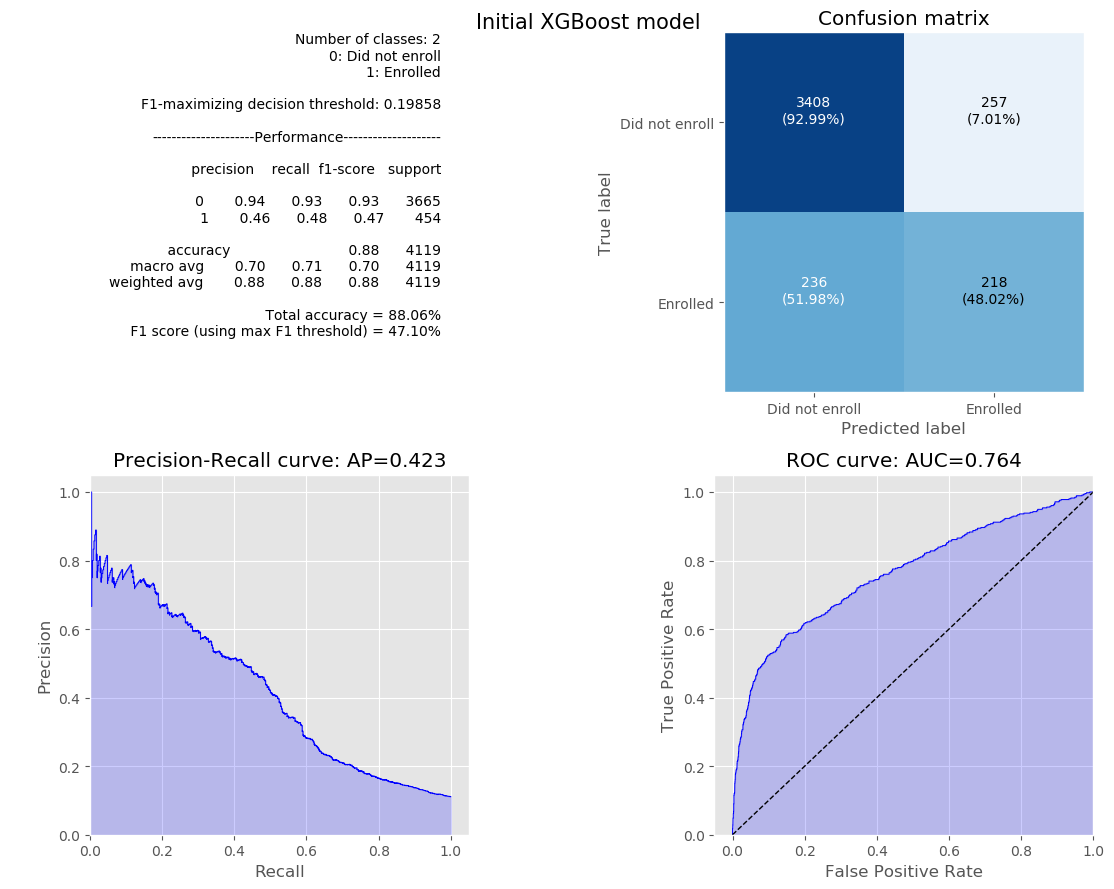

In [24]:
%matplotlib inline

report = util.reporting.generate_binary_classification_report(
    y_real=df_eval["y"].values,
    y_predict_proba=df_eval["y_prob"].values,
    # y_predict_label not available for XGBoost output format
    # Optionally set decision_threshold=0.5 to apply a specific threshold, instead of maximizing F1:
    # decision_threshold=0.5,
    class_names_list=["Did not enroll", "Enrolled"],
    title="Initial XGBoost model",
)

# Store the model quality report locally and on Amazon S3:
with open("data/report-xgboost.json", "w") as f:
    json.dump(report, f, indent=2)
model_quality_s3uri = f"s3://{bucket_name}/{bucket_prefix}/{xgb_model.name}/model-quality.json"
!aws s3 cp data/report-xgboost.json {model_quality_s3uri}

### Register and share the model

훈련된 모델은 이미 SageMaker API에서 배포 및 재사용할 수 있습니다. (예: [Models page of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/models))

그러나 [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html)에서 카탈로그를 만들어 검색 가능성과 거버넌스를 개선할 수 있습니다. 여기서 I/O 형식 및 위에서 생성된 모델 품질 보고서를 포함한 추가 메타데이터를 연결할 수 있습니다:

In [15]:
xgb_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name="sm101-dm",
    description="Initial XGBoost model",
    model_metrics=sagemaker.model_metrics.ModelMetrics(
        model_statistics=sagemaker.model_metrics.MetricsSource(
            content_type="application/json",
            s3_uri=model_quality_s3uri,
        ),
    ),
    domain="MACHINE_LEARNING",
    task="CLASSIFICATION",
    sample_payload_url=test_data_s3uri,
)

SageMaker Studio에서 버전 레지스트리 모델 패키지를 탐색하고 관리할 수 있습니다: 자동화된 배포를 트리거하기 위해 새 버전 검토 및 승인 포함

## Hyperparameter Optimization (HPO)

> ⏰ *아래의 기본 설정을 사용할 경우 하이퍼파라미터 조정 작업을 완료하는데 최대 20분이 소요될 수 있습니다*

AutoGluon과 같은 AutoML 프레임워크는 모델 앙상블 캡슐화하려고 시도하지만, XGBoost와 같은 단일 알고리즘 접근 방식은 종종 특정 문제에 대한 `alpha`, `eta` 및 `max_depth` 와 같은 설정에 대한 최상의 값을 찾기 위해 하이퍼파라미터 튜닝의 이점을 얻을 수 있습니다.

이러한 매개 변수 조합을 직접 탐색하는 것은 시간이 많이 걸릴 수 있습니다. 특히 매개 변수를 두 개 이상 고려하는 경우에는 더욱 그렇습니다.

[SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) 은 지능형 탐색 및 최적화 작업을 자동으로 실행할 수 있으므로 이러한 실험을 관리하는 대신 통찰력을 구축하고 적용하는데 집중할 수 있습니다.

아래와 같이 표준 `Estimator` 주위에 [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) wrapper 를 설정할 수 있습니다. 주요 요구사항은:

1. Your job outputs at least one **metric** which the tuner can maximize or minimize (this is handled automatically for most built-in algorithms)
1. Specify **ranges for the hyperparameters** you'd like to explore
1. Specify the **strategy and resource limits** for the job

SageMaker HPO 는 그리드 및 랜덤 검색과 같은 탐색 도구지만 베이지안 최적화 및 하이퍼밴드와 같은 효율적인 HPO 지향 최적화 도구를 포함한 다양한 [전략](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) 을 지원 합니다.

이 예에서는 베이지안 검색을 사용하여 XGBoost 모델 [See Machine Learning Key Concepts](https://docs.aws.amazon.com/machine-learning/latest/dg/amazon-machine-learning-key-concepts.html) 의 ROC 곡선 아래 영역을 최적화 합니다.

In [16]:
%%time

# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

# Target metric is already built in to the algorithm, so we just specify the name:
objective = "validation:auc"

# Configure hyperparameter ranges to explore:
ranges = {
    "num_round": IntegerParameter(1, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# Configure the tuner:
xgb_tuner = HyperparameterTuner(
    estimator=xgb_estimator,  # The SageMaker estimator object
    hyperparameter_ranges=ranges,
    max_jobs=15,  # Max total number of training jobs
    max_parallel_jobs=3,  # How many training jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,
    objective_type="Maximize",  # For AUC, higher = better
)

# Start the job:
xgb_tuner.fit(
    {
        "train": sagemaker.inputs.TrainingInput(train_data_s3uri, content_type="csv"),
        "validation": sagemaker.inputs.TrainingInput(validation_data_s3uri, content_type="csv"),
    },
    wait=True,  # Optionally block the notebook until the job is complete.
)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230404-0359


.......................................................................................................................................................................!
CPU times: user 844 ms, sys: 77.8 ms, total: 921 ms
Wall time: 14min 21s


`max_parallel_jobs` 는 직업 실행 시간과 결과 품질 간 **trade-off** 입니다: 더 많은 작업이 병렬로 실행될 수록 `max_jobs` 가 더 빨리 완료되지만, 다음에 시도할 매개 변수 조합을 선택할 때 전략이 완료된 작업에 대한 정보를 더 적게 갖게 됩니다.

훈련 및 트랜스폼 작업과 마찬가지로 하이퍼파라미터 튜닝은 노트북과 별도로 실행되므로 연결이 끊기거나 종료되어도 중단되지 않습니다. SageMaker 콘솔의 [Training > Hyperparameter tuning jobs page](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) 와 [DescribeHyperParameterTuningJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html) 에서 작업 진행 상황을 추적할 수 있습니다.

HPO가 백그라운드에서 실행되는 동안 노트북에서 작업을 계속하려면 언제든지 `wait=False` 를 설정하거나 셀을 중단 (도구 모음의 사각형 정지 ⏹ 버튼)할 수 있습니다. 나중에 아래와 같이 `tuner.wait()` 를 호출해 활성 작업의 대기를 다시 시작할 수 있습니다. Estimator와 마찬가지로 튜닝 작업이 완료될 때까지 튜너의 모델을 `deploy()` 할 수 없습니다.

In [ ]:
xgb_tuner.wait()

모델 튜닝으로 생성된 개별 훈련 작업은 수동으로 생성된 작업과 마찬가지로 SageMaker에 나열되며, HPO 작업은 객관적인 메트릭을 기반으로 모델의 리더보드를 구축합니다.

이 예에서는 단순히 "최상의" 모델을 배포하지만, 작업을 탐색하여 더 깊은 인사이트를 얻을 수도 있습니다. 예제는 [this sample notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) 을 참조하세요.


### Deploy and test the optimized model

단일 훈련과 마찬가지로, 하이퍼파라미터 튜닝 실행 결과를 배치 또는 온라인 추론에 사용할 수 있습니다.

[HyperparameterTuner.deploy(...)](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html#sagemaker.tuner.HyperparameterTuner.deploy) 메서드를 직접 호출하여 승리한 모델을 엔드포인트에 배포할 수 있지만, 이전과 마찬가지로 먼저 `Model` 오브젝트를 생성하여 나중에 SageMaker 모델 레지스트리에 다시 연결 합니다.

In [17]:
best_job_name = xgb_tuner.best_training_job()
print("Best training job from HPO run:", best_job_name)

hpo_model = sagemaker.estimator.Estimator.attach(best_job_name).create_model()

Best training job from HPO run: sagemaker-xgboost-230404-0359-008-fcf12e5c

2023-04-04 04:07:01 Starting - Preparing the instances for training
2023-04-04 04:07:01 Downloading - Downloading input data
2023-04-04 04:07:01 Training - Training image download completed. Training in progress.
2023-04-04 04:07:01 Uploading - Uploading generated training model
2023-04-04 04:07:01 Completed - Training job completed


In [18]:
hpo_predictor = hpo_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-04-04-04-13-28-466
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-04-04-04-13-29-069
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-04-04-04-13-29-069


----!

### Use the endpoint

SageMaker SDK의 [Predictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) 클래스는 노트북에서 유용한 추론 엔드포인트를 생성하고 호출하기 위한 높은 수준의 Python wrapper를 제공 합니다. 컨슈머 어플리케이션은 이러한 추가 라이브러리 종속성을 피하기 위해 낮은 수준의 [SageMaker Runtime API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_Operations_Amazon_SageMaker_Runtime.html) ([Boto3 in Python](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html) 또는 다른 언어의 다른 AWS SDK)를 사용할 수도 있습니다.

SageMaker 는 표 형식의 데이터를 넘어 광범위한 유즈 케이스를 지원하는 범용 ML 플랫폼이므로 엔드포인트 요청 (여기서는 CSV)에서 어떤 유형의 콘텐츠를 전송하고 응답 (여기서는 JSON)에 대해 SDK [serializer](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) 및 [deserializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html)를 통해 명시적으로 구성해야 합니다. 또한 자체 클래스를 정의하여 `predictor.predict()` 메서드의 Python I/O 인터페이스와 HTTPS 엔트포인트로 전송되는 온더와이어 데이터 형식을 완전히 사용자 정의할 수도 있습니다.

다시 말하지만, 미리 빌드된 알고리즘을 사용할 때는 [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) 를 참조하여 추론 시 지원되는 입력 및 출력 형식을 확인하세요.

앞서 일괄 변환의 경우와 유사하게 모델에서 `text/csv` 입력을 보내고 `text/csv` 출력을 요청하겠습니다:

In [19]:
# getting the predicted probabilities of the best model
hpo_probabilities = np.array(
    hpo_predictor.predict(test_data.drop(["y"], axis=1).values),
    dtype=float,
).squeeze()

hpo_probabilities

array([0.04321304, 0.06200956, 0.08277833, ..., 0.08945711, 0.05486276,
       0.09147384])

> ⚠️ **Note:** 위의 single `predict()` 호출은 **전체 테스트 데이터 집합을 한번에 일괄처리**하여 single `InvokeEndpoint` 요청을 만듭니다. 이와 같은 작은 데이터 세트에서는 괜찮지만, 실제 사용 사례에서는 처리량 효율성(큰 배치로 통신 오버헤드 감소), 엔드포인트 메모리 요구 사항, 페이로드 크기 제한(실시간 엔드포인트의 경우 6MB, 작성 시점 기준) 간에 균형을 맞춰야 합니다.

우리의 모델은 잠재 고객이 정기 예금에 가입할 확률 점수 (in the interval [0,1]) 를 계산 했습니다. 이러한 예측을 노트북의 원본 데이터 프레임에 다시 결합하여 앞서의 일괄처리 결과와 유사한 성능을 탐색할 수 있습니다:

Using inferred F1-maximizing threshold for metrics
upload: data/report-xgbhpo.json to s3://sagemaker-us-east-1-151772765882/sm101/direct-marketing/sagemaker-xgboost-2023-04-04-04-13-28-466/model-quality.json


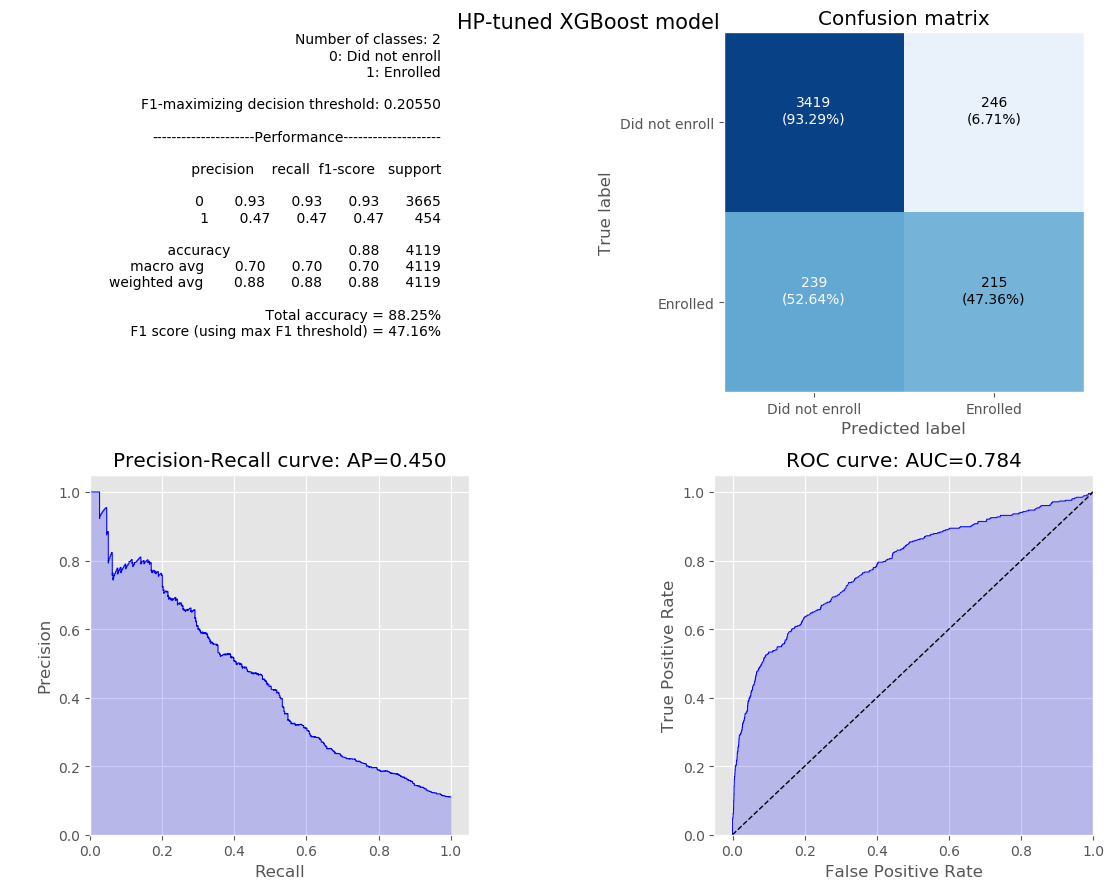

In [26]:
%matplotlib inline

hpo_report = util.reporting.generate_binary_classification_report(
    y_real=test_data["y"].values,
    y_predict_proba=hpo_probabilities,
    # y_predict_label not available for XGBoost output format
    # Optionally set decision_threshold=0.5 to apply a specific threshold, instead of maximizing F1:
    # decision_threshold=0.5,
    class_names_list=["Did not enroll", "Enrolled"],
    title="HP-tuned XGBoost model",
)

# Store the model quality report locally and on Amazon S3:
with open("data/report-xgbhpo.json", "w") as f:
    json.dump(hpo_report, f, indent=2)
hpo_quality_s3uri = f"s3://{bucket_name}/{bucket_prefix}/{hpo_model.name}/model-quality.json"
!aws s3 cp data/report-xgbhpo.json {hpo_quality_s3uri}

...마지막으로 이 튜닝된 모델을 SageMaker Model Registry group에 두 번째 후보 버전으로 등록할 수 있습니다:

In [21]:
hpo_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name="sm101-dm",
    description="HP-tuned XGBoost model",
    model_metrics=sagemaker.model_metrics.ModelMetrics(
        model_statistics=sagemaker.model_metrics.MetricsSource(
            content_type="application/json",
            s3_uri=hpo_quality_s3uri,
        ),
    ),
    domain="MACHINE_LEARNING",
    task="CLASSIFICATION",
    sample_payload_url=test_data_s3uri,
)

▶️ SageMaker Model Registry에서 Model Group **열기**

- 모델 그룹에서 **여러 버전을 선택**하려면 `Shift+Click` 또는 `Control+Click` 할 수 있습니다.
- 여러 버전을 선택한 상태에서 `Right Click` 히고 `Compare model versions` 을 선택하면 여러 모델의 차트와 통계를 나란히 비교할 수 있습니다.

## Conclusions

이 노트북에서는 [**SageMaker Autopilot**](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html) 으로 코딩 없이도 새로운 표 형식 ML 프로젝트를 정확도가 높고 배포 가능한 모델로 가속화하는 방법을 살펴보았습니다. 또한 [SageMaker built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) 과 [automatic hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)을 사용하여 일반적인 알고리즘을 처음부터 구현하지 않고도 모델을 사용자 지정할 수 있는 방법을 자세히 살펴봤습니다.

또한 [SageMaker Feature Store](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store.html) 가 공유 Feature 데이터를 카탈로그화 하는데 어떻게 도움이 되는지, [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html) 가 학습된 모델을 추적하고 관리하는데 어떻게 도움이 되는지데 대한 간략한 소개도 보았습니다. 이러한 MLOps 기능에 대한 자세한 내용은 설명서 및 공식 [SageMaker notebook examples repository](https://github.com/aws/amazon-sagemaker-examples)를 참조하세요.

이번 HPO 실행에서는 런타임을 빠르게 유지하기 위해 비교적 적은 수의 트라이얼을 사용했기 때문에 큰 개선을 느끼지 못했을 수도 있습니다: 하지만 매개변수의 공간이 커지고 알고리즘이 최적의 조합을 탐색할 수 있도록 충분한 컴퓨팅 리소스를 할당할 수 있을때 HPO가 특히 유용 합니다.

[SageMaker Autopilot](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html) 은 새로운 표 형식 데이터 프로젝트에서 강력한 초기 결과를 제공하는 가장 빠른 방법일 수 있지만, SageMaker 빌트인 알고리즘은 텍스트 및 시각에서 더 틈새 표 형식 문제 유형에 이르기까지 광범위한 사용 사례를 지원 합니다. 빌트인 알고리즘을 SageMaker HPO와 결합하면 정확도를 크게 높일 수 있습니다.

실제로 Autopilot은 내부에서 이러한 동일한 도구를 많이 사용 합니다: HPO 모드에서 실행할 때 HPO 작업 생성, 데이터 전처리 실험을 위한 SageMaker 프로세싱 사용, XGBoost 및 AutoGluon-Tabular 알고리즘 활용 등 입니다.

## Releasing cloud resources

훈련 작업 클러스터는 작업이 중지되면 자동으로 종료되지만, 추론 엔드포인트는 명시적으로 삭제할 떄까지 프로비저닝된 상태로 유지됩니다.

불필요한 요금이 부과되지 않도록 하려면 실험이 끝나면 다음 코드를 실행하여 AutoGluon model endpoint를 정리하세요. SageMaker 콘솔의 [Inference > Endpoints page](https://console.aws.amazon.com/sagemaker/home?#/endpoints) 에서 실행 중인 다른 엔드포인트가 있는지 확인할 수도 있습니다.

In [ ]:
# hpo_predictor.delete_endpoint(delete_endpoint_config=True)